In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix
import numpy as np

color = '#4682B4'
df = pd.read_parquet('../data/manual_predictions.parquet')
comments_df =pd.read_parquet('../data/comments_sample.parquet')

df = df[['id', 'rating']]\
    .merge(
    comments_df[['id', 'rating', 'language']]
    .rename(columns={'rating':'real_rating'}),
    on='id',
    how='inner'
    ).drop(columns='id')\
    .rename(columns={'rating':'manual_prediction'})


df[f'is_inconsistent_manual'] = (
    (df[f'manual_prediction'] - df['real_rating']).abs() > 1
    ).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   manual_prediction       1000 non-null   int64 
 1   real_rating             1000 non-null   int64 
 2   language                1000 non-null   object
 3   is_inconsistent_manual  1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [55]:
def plot_rating_distribution(
        df,
        rating_col='rating',
        color='steelblue',
        figsize=(10, 6),
        title='Distribuição de Notas',
        xlabel='Nota',
        ylabel='Frequência'):
    # Conta e ordena os ratings
    rating_counts = df[rating_col].value_counts().sort_index()
    total = rating_counts.sum()

    # Cria figura e eixos
    fig, ax = plt.subplots(figsize=figsize)

    # Desenha barras com a cor escolhida
    rating_counts.plot(kind='bar', color=color, ax=ax)

    # Ajustes de rótulos e título
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylim(0, rating_counts.max() * 1.1)

    # Anotações: contagem e percentual
    for i, count in enumerate(rating_counts):
        pct = (count / total) * 100
        ax.text(i, count, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom')

    # Rotaciona os tick labels no eixo x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

    return fig, ax

def plot_rating_distribution_by_lang(
    df,
    rating_col='rating',
    lang_col='language',
    langs=('pt', 'en'),
    color='steelblue',
    figsize=(12, 6),
    title_fmt='Distribuição de Notas ({lang})',
    xlabel='Nota',
    ylabel='Frequência'
    ):
    """
    Plota lado a lado a distribuição de ratings para cada linguagem em langs.

    Parâmetros:
    - df: pandas.DataFrame contendo as colunas de rating e language
    - rating_col: nome da coluna das notas (default 'rating')
    - lang_col: nome da coluna de linguagem (default 'language')
    - langs: tupla com as duas labels de linguagem a serem plotadas (ex: ('pt','en'))
    - color: cor das barras (qualquer valor aceito pelo Matplotlib)
    - figsize: tamanho da figura (width, height)
    - title_fmt: formato do título, deve conter '{lang}' para interpolar a linguagem
    - xlabel, ylabel: rótulos dos eixos
    """
    fig, axes = plt.subplots(ncols=2, figsize=figsize, dpi=120, sharey=False)

    for ax, lang in zip(axes, langs):
        sub = df[df[lang_col] == lang]
        counts = sub[rating_col].value_counts().sort_index()
        total = counts.sum()

        # plot
        counts.plot(kind='bar', color=color, ax=ax)
        ax.set_title(title_fmt.format(lang=lang.upper()), fontsize=14, fontweight='bold')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, counts.max() * 1.1)

        # annotate
        for i, count in enumerate(counts):
            pct = (count / total) * 100
            ax.text(i, count, f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=8)

        ax.set_xticklabels(counts.index.astype(str), rotation=0)

    plt.tight_layout()
    plt.show()
    return fig, axes

def plot_rating_distribution_all(
    df,
    rating_col='rating',
    lang_col='language',
    langs=('pt', 'en'),
    color='steelblue',
    figsize=(18, 6),
    title_fmt='Distribuição de Notas ({label})',
    xlabel='Nota',
    ylabel='Frequência'
):
    """
    Plota três gráficos em sequência (lado a lado):
      1) distribuição total de ratings
      2) distribuição de ratings para linguagem 'pt'
      3) distribuição de ratings para linguagem 'en'

    Parâmetros:
    - df: pandas.DataFrame contendo as colunas de rating e language
    - rating_col: nome da coluna dos ratings (default 'rating')
    - lang_col: nome da coluna de linguagem (default 'language')
    - langs: tupla com as duas labels de linguagem a plotar (ex: ('pt','en'))
    - color: cor das barras (qualquer valor aceito pelo Matplotlib)
    - figsize: tamanho da figura (width, height)
    - title_fmt: formato do título, deve conter '{label}' para interpolar 'Total' ou a sigla da linguagem
    - xlabel, ylabel: rótulos dos eixos

    Retorna:
    - fig, axes: objetos Matplotlib da figura e dos eixos plotados
    """
    # Prepara as três subsets: total + cada linguagem
    subsets = [('Total', df)] + [(lang.upper(), df[df[lang_col] == lang]) for lang in langs]

    fig, axes = plt.subplots(ncols=3, figsize=figsize, dpi=120, sharey=False)

    for ax, (label, subdf) in zip(axes, subsets):
        counts = subdf[rating_col].value_counts().sort_index()
        total = counts.sum()

        # desenha barras
        counts.plot(kind='bar', color=color, ax=ax)
        ax.set_title(title_fmt.format(label=label), fontsize=14, fontweight='bold')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, counts.max() * 1.1)

        # anotação: contagem e percentual
        for i, count in enumerate(counts):
            pct = (count / total) * 100 if total > 0 else 0
            ax.text(i, count, f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=8)

        ax.set_xticklabels(counts.index.astype(str), rotation=0)

    plt.tight_layout()
    plt.show()
    return fig, axes

def plot_confusion_matrix(
    df,
    real_col='real_rating',
    pred_col='manual_prediction',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(8, 6),
    title='Matriz de Confusão'
    ):
    """
    Gera e plota a matriz de confusão entre valores reais e predições manuais.

    Parâmetros:
    - df: pandas.DataFrame contendo as colunas de rótulos reais e predições
    - real_col: nome da coluna de rótulos reais (default 'real_rating')
    - pred_col: nome da coluna de predições (default 'manual_prediction')
    - labels: lista de labels na ordem desejada (default inferida dos dados)
    - cmap: colormap usado para o heatmap
    - figsize: tamanho da figura (width, height)
    - title: título do gráfico
    """
    # Extrai valores
    y_true = df[real_col]
    y_pred = df[pred_col]

    # Define labels
    if labels is None:
        labels = np.unique(np.concatenate([y_true.unique(), y_pred.unique()]))

    # Calcula matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_perc = np.round(cm / cm_sum * 100, 1)

    # Plota
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Ticks e labels
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Predição',
        ylabel='Real',
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Anotações de contagem e percentual em cada célula
    fmt = '{}\n({:.1f}%)'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(
                j, i,
                fmt.format(count, perc),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10
            )

    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_confusion_matrix_with_borders(
    df,
    real_col='real_rating',
    pred_col='manual_prediction',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(8, 6),
    title='Matriz de Confusão',
    border_cells=(1,2,6,7,8,12,13,14,18,19,20,24,25),
    border_kwargs=None
):
    """
    Gera e plota a matriz de confusão, adiciona borda preta em células específicas
    (contagem da esquerda para a direita, de cima para baixo, 1 a N²) e torna o texto
    de anotação dessas células em negrito.

    Parâmetros:
    - df: DataFrame com as colunas real_col e pred_col
    - real_col: nome da coluna com valores reais
    - pred_col: nome da coluna com predições
    - labels: ordem dos labels a usar (default: inferida)
    - cmap: colormap para o heatmap
    - figsize: tamanho da figura
    - title: título do gráfico
    - border_cells: tupla de índices de célula (1-based) onde desenhar borda
    - border_kwargs: dict com argumentos de estilo para Rectangle (ex: linewidth)
    """
    # Extrai valores
    y_true = df[real_col]
    y_pred = df[pred_col]

    # Define labels
    if labels is None:
        labels = np.unique(np.concatenate([y_true.unique(), y_pred.unique()]))

    # Calcula matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    n = cm.shape[0]
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_perc = np.round(cm / cm_sum * 100, 1)

    # Plot principal
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Configura ticks
    ax.set(
        xticks=np.arange(n),
        yticks=np.arange(n),
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Predição Manual',
        ylabel='Real',
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Borda padrão
    if border_kwargs is None:
        border_kwargs = dict(edgecolor='black', facecolor='none', linewidth=3)

    # Anotações e bordas
    fmt = '{}\n({:.1f}%)'
    thresh = cm.max() / 2
    for i in range(n):
        for j in range(n):
            count = cm[i, j]
            perc = cm_perc[i, j]
            cell_num = i * n + j + 1

            # Define estilo de fonte: negrito se estiver na lista de border_cells
            text_kwargs = dict(
                ha='center', va='center',
                color='white' if count > thresh else 'black',
                fontsize=10,
                fontweight='bold' if cell_num in border_cells else 'normal'
            )
            ax.text(j, i, fmt.format(count, perc), **text_kwargs)

            # Desenha borda se necessário
            if cell_num in border_cells:
                ax.add_patch(
                    Rectangle((j - 0.5, i - 0.5), 1, 1, **border_kwargs)
                )

    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_confusion_matrix_by_language(
    df,
    real_col='real_rating',
    pred_col='manual_prediction',
    lang_col='language',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(18, 6),
    titles=('Todos', 'PT', 'EN'),
    border_cells=(1,2,6,7,8,12,13,14,18,19,20,24,25),
    border_kwargs=None
):
    """
    Plota três matrizes de confusão lado a lado:
      1) com todos os dados,
      2) apenas dados em português (lang_col == 'pt'),
      3) apenas dados em inglês (lang_col == 'en').

    Parâmetros:
    - df: pandas.DataFrame com as colunas real_col, pred_col e lang_col
    - real_col: nome da coluna de rótulos reais
    - pred_col: nome da coluna de predições
    - lang_col: nome da coluna de linguagem (com valores 'pt' e 'en')
    - labels: lista de rótulos na ordem desejada (default: inferida)
    - cmap: colormap para os heatmaps
    - figsize: tupla (width, height) para o tamanho da figura
    - titles: tupla de títulos para cada subplot (total, pt, en)
    - border_cells: índices 1-based das células a receber borda e texto em negrito
    - border_kwargs: dict de estilo para Rectangle (edgecolor, linewidth, etc.)
    """
    # Default style for borders
    if border_kwargs is None:
        border_kwargs = dict(edgecolor='black', facecolor='none', linewidth=3)

    # Prepare y_true and y_pred for all data to infer labels if needed
    y_true_all = df[real_col]
    y_pred_all = df[pred_col]
    if labels is None:
        labels = np.unique(np.concatenate([y_true_all.unique(), y_pred_all.unique()]))

    # Prepare subsets
    subsets = [
        (titles[0], df),
        (titles[1], df[df[lang_col] == 'pt']),
        (titles[2], df[df[lang_col] == 'en']),
    ]

    n_labels = len(labels)
    fig, axes = plt.subplots(ncols=3, figsize=figsize, dpi=120, sharey=True)
    
    for ax, (title, subdf) in zip(axes, subsets):
        # Compute confusion matrix
        y_true = subdf[real_col]
        y_pred = subdf[pred_col]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_perc = np.round(cm / cm_sum * 100, 1)

        # Plot heatmap
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)

        # Configure ticks and labels
        ax.set(
            xticks=np.arange(n_labels),
            yticks=np.arange(n_labels),
            xticklabels=labels,
            yticklabels=labels,
            xlabel='Predição Manual',
            ylabel='Real' if title == titles[0] else '',
            title=title
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

        # Annotate cells and draw borders
        thresh_abs = cm.max() / 2
        for i in range(n_labels):
            for j in range(n_labels):
                cell_idx = i * n_labels + j + 1
                count = cm[i, j]
                pct = cm_perc[i, j]
                text = f"{count}\n({pct:.1f}%)"
                weight = 'bold' if cell_idx in border_cells else 'normal'
                color_txt = 'white' if cm[i, j] > thresh_abs else 'black'
                ax.text(
                    j, i, text,
                    ha='center', va='center',
                    fontsize=10, fontweight=weight,
                    color=color_txt
                )
                if cell_idx in border_cells:
                    ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, **border_kwargs))

    plt.tight_layout()
    plt.show()
    return fig, axes

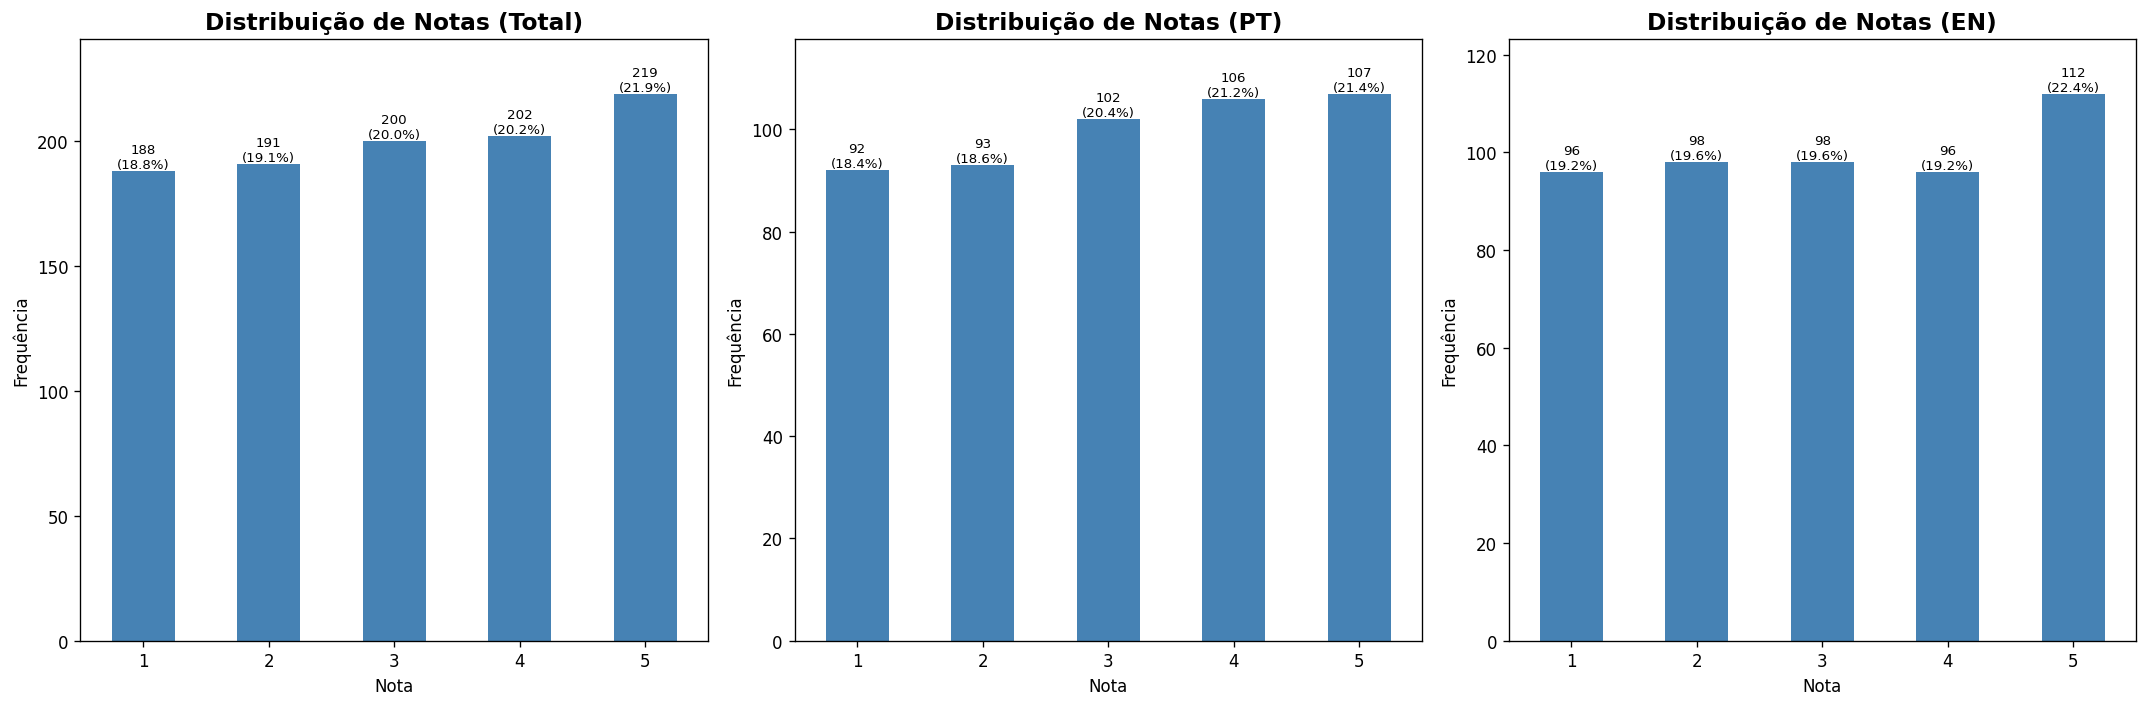

(<Figure size 2160x720 with 3 Axes>,
 array([<Axes: title={'center': 'Distribuição de Notas (Total)'}, xlabel='Nota', ylabel='Frequência'>,
        <Axes: title={'center': 'Distribuição de Notas (PT)'}, xlabel='Nota', ylabel='Frequência'>,
        <Axes: title={'center': 'Distribuição de Notas (EN)'}, xlabel='Nota', ylabel='Frequência'>],
       dtype=object))

In [56]:
# plot_rating_distribution(df, rating_col='real_rating', color=color)
# plot_rating_distribution_by_lang(df, rating_col='real_rating', color=color)
plot_rating_distribution_all(df, rating_col='real_rating', color=color)

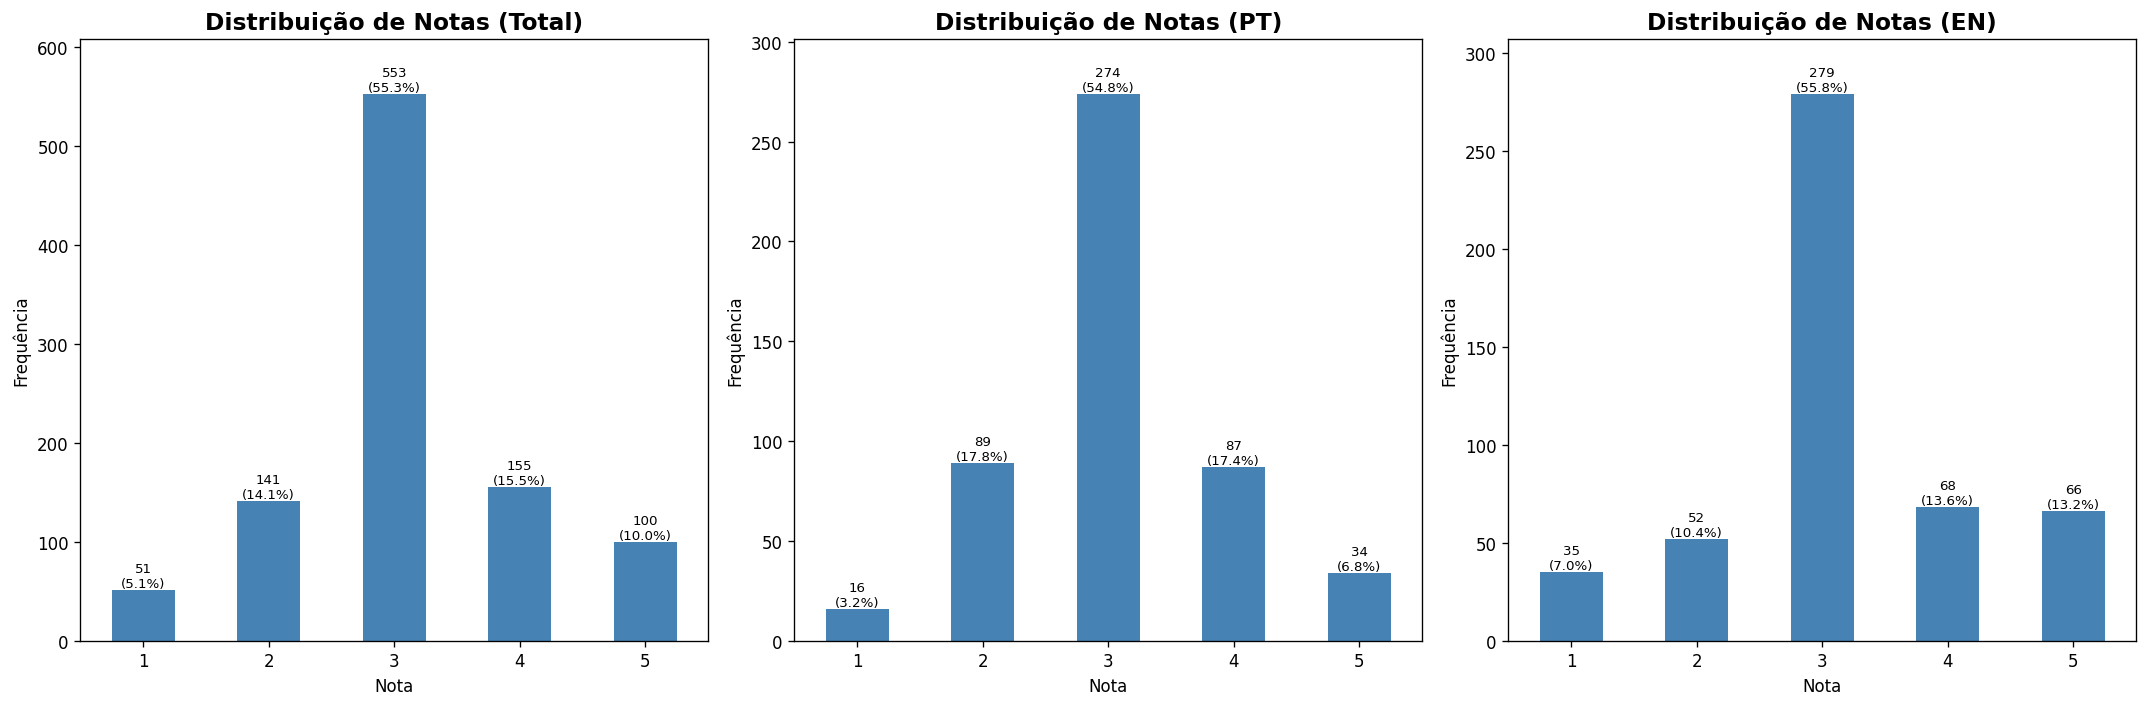

(<Figure size 2160x720 with 3 Axes>,
 array([<Axes: title={'center': 'Distribuição de Notas (Total)'}, xlabel='Nota', ylabel='Frequência'>,
        <Axes: title={'center': 'Distribuição de Notas (PT)'}, xlabel='Nota', ylabel='Frequência'>,
        <Axes: title={'center': 'Distribuição de Notas (EN)'}, xlabel='Nota', ylabel='Frequência'>],
       dtype=object))

In [57]:
plot_rating_distribution_all(df, rating_col='manual_prediction', color=color)

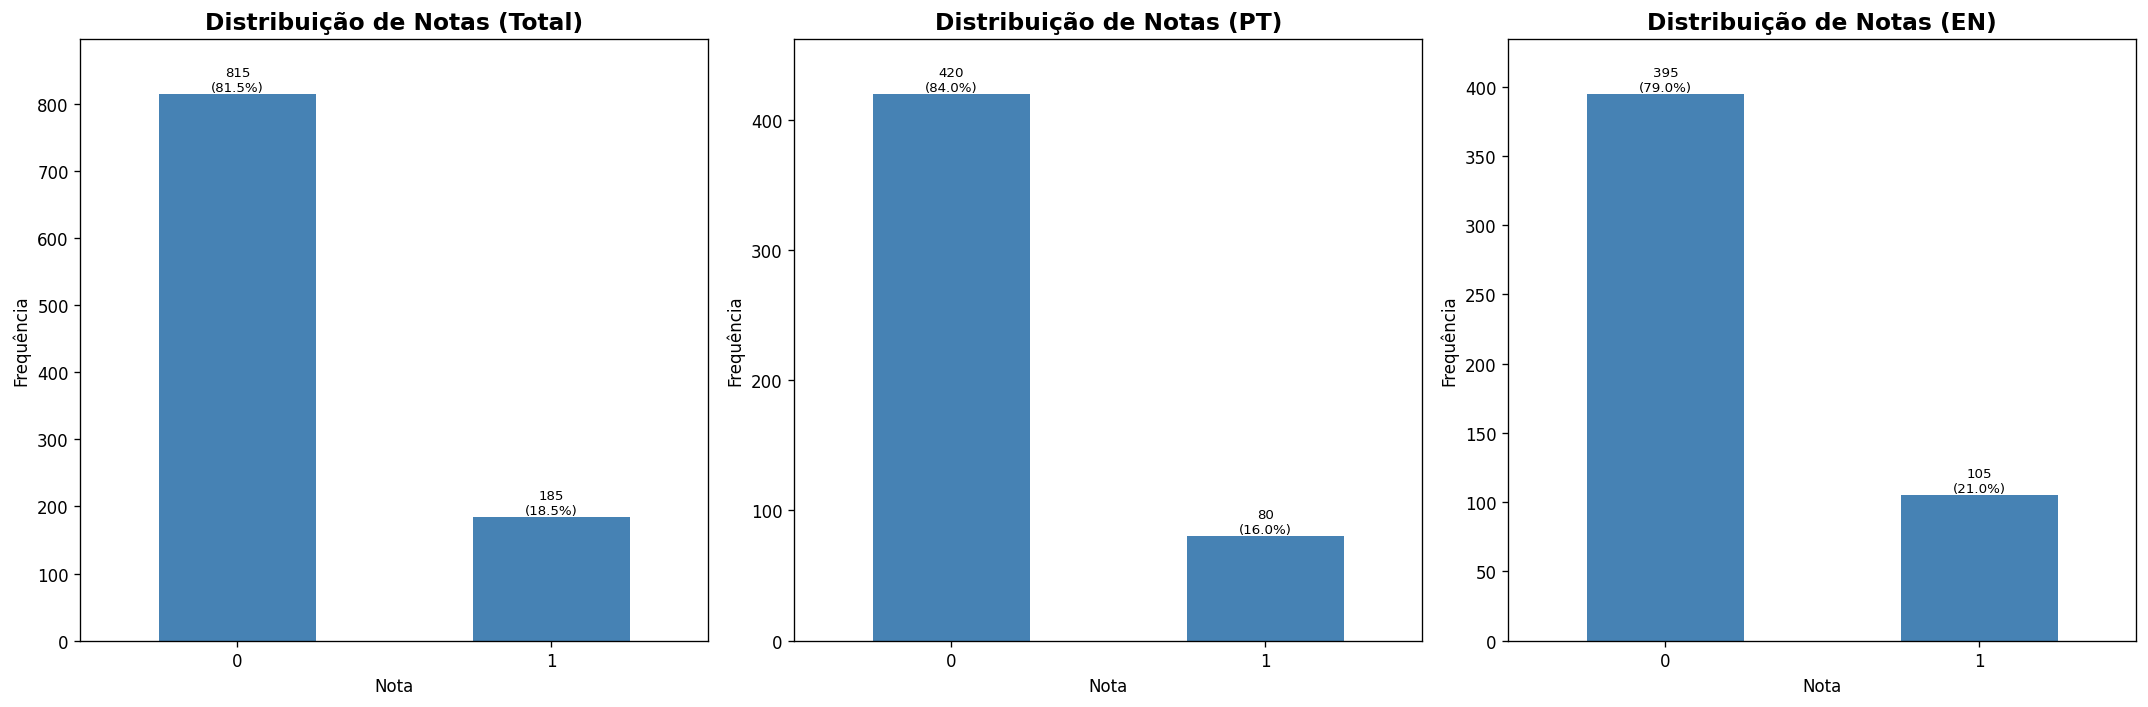

(<Figure size 2160x720 with 3 Axes>,
 array([<Axes: title={'center': 'Distribuição de Notas (Total)'}, xlabel='Nota', ylabel='Frequência'>,
        <Axes: title={'center': 'Distribuição de Notas (PT)'}, xlabel='Nota', ylabel='Frequência'>,
        <Axes: title={'center': 'Distribuição de Notas (EN)'}, xlabel='Nota', ylabel='Frequência'>],
       dtype=object))

In [58]:
plot_rating_distribution_all(df, rating_col='is_inconsistent_manual', color=color)

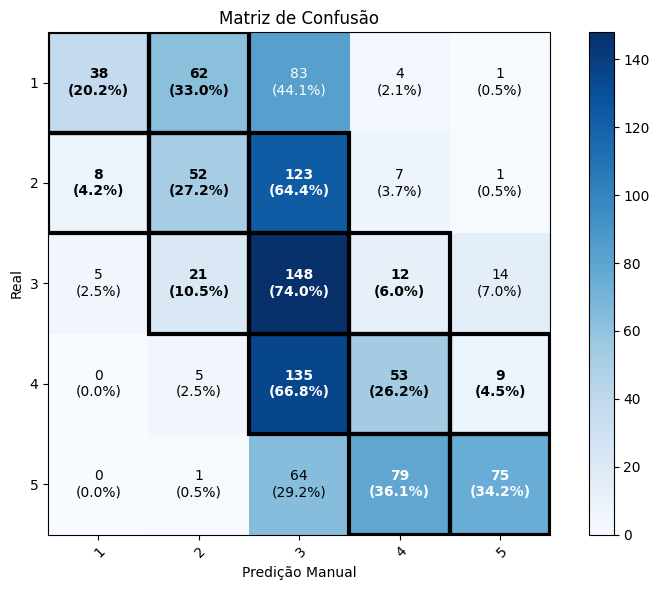

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predição Manual', ylabel='Real'>)

In [59]:
plot_confusion_matrix_with_borders(df)

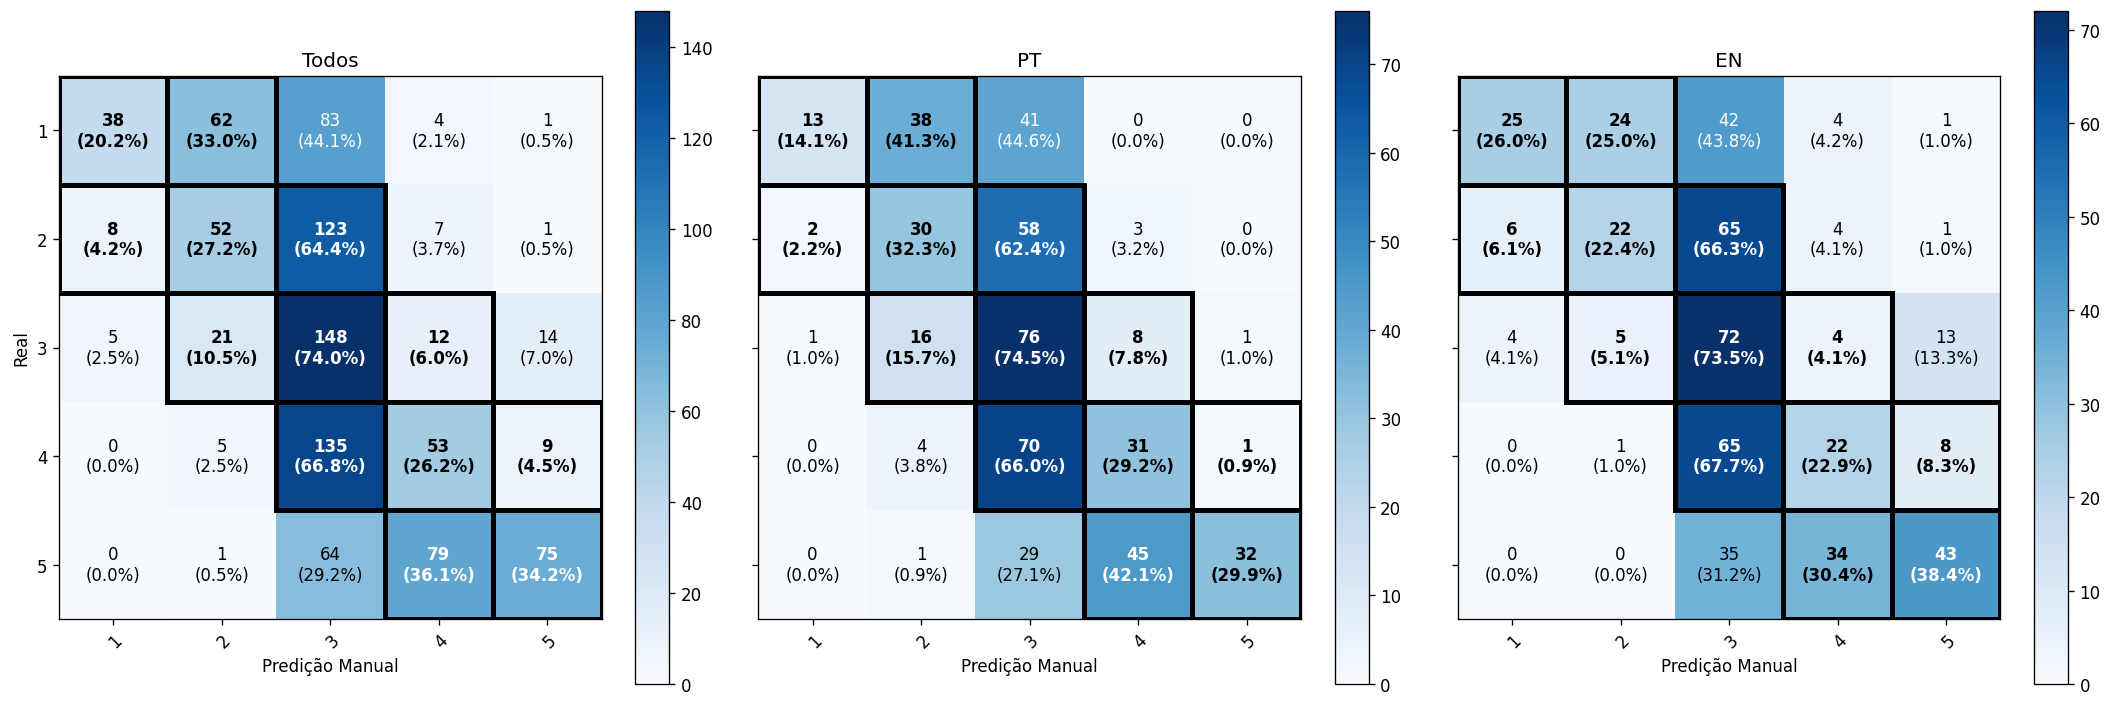

(<Figure size 2160x720 with 6 Axes>,
 array([<Axes: title={'center': 'Todos'}, xlabel='Predição Manual', ylabel='Real'>,
        <Axes: title={'center': 'PT'}, xlabel='Predição Manual'>,
        <Axes: title={'center': 'EN'}, xlabel='Predição Manual'>],
       dtype=object))

In [60]:
plot_confusion_matrix_by_language(df)